<a href="https://colab.research.google.com/github/saimaayub/DS-project/blob/main/FPR_CODING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas

#Importing required libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#**EDA(Exploratory Data Analysis):**


1.   EDA includes making a dataset that contains daily data for both energy consumption and weather variables.
2.   Plotting these weather variables against energy consumption to observe their relationships, correlation.
3. Plotting a heatmap to observe correlations of weather variables with energy consumption.

#Merging fragments of whole data converted into daily data in one dataframe.

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Defining csv file paths in google drive
csv_file_paths = [
    '/content/drive/MyDrive/50DailyData.csv',
    '/content/drive/MyDrive/51DailyData.csv',
    '/content/drive/MyDrive/101DailyData.csv'
]

# Loading each csv file into a DataFrame to store them in a list
dataframes = []
for file_path in csv_file_paths:
    df = pd.read_csv(file_path)
    dataframes.append(df)

# To make a single dataframe concatenate all DataFrames.
merged_df1 = pd.concat(dataframes, ignore_index=True)

Mounted at /content/drive


In [5]:
merged_df1.head()

,index,Date,Average KWH per Day
0,0,2012-05-18,0.177275
1,1,2012-05-19,0.177462
2,2,2012-05-20,0.189562
3,3,2012-05-21,0.229199
4,4,2012-05-22,0.170351


In [6]:
merged_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   index                1953 non-null   int64  
 1   Date                 1953 non-null   object 
 2   Average KWH per Day  1953 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 45.9+ KB


#Merge data again to avoid multiple entries for same date by averaging energy consumption values for a single date.  

In [7]:
# Convert to DateTime format
merged_df1['Date'] = pd.to_datetime(merged_df1['Date'])

# To merge data by Date calculating the mean of 'KWH/hh (per half hour)'
daily_data = merged_df1.groupby(merged_df1['Date'].dt.date)['Average KWH per Day'].mean().reset_index()

# To avoid the errors renaming the columns for clarity
daily_data.columns = ['Date', 'Average KWH']

# Verify the daily_data DataFrame
print(f"Daily data shape: {daily_data.shape}")
print(daily_data.head())

# Save the daily data obtained as a csv file in google drive
daily_csv_file_path = '/content/drive/MyDrive/LCL-Final-Merged-DailyData.csv'
daily_data.to_csv(daily_csv_file_path, index=False)

print(f"Daily data saved to: {daily_csv_file_path}")

Daily data shape: (652, 2)
         Date  Average KWH
0  2012-05-18     0.177275
1  2012-05-19     0.177462
2  2012-05-20     0.189562
3  2012-05-21     0.222067
4  2012-05-22     0.163837
Daily data saved to: /content/drive/MyDrive/LCL-Final-Merged-DailyData.csv


In [8]:
print("Energy data date range:", merged_df1['Date'].min(), merged_df1['Date'].max())
print("Energy data consumption range:", merged_df1['Average KWH per Day'].min(), merged_df1['Average KWH per Day'].max())

Energy data date range: 2012-05-18 00:00:00 2014-02-28 00:00:00
Energy data consumption range: 0.1332413793103448 0.3905631318813131


#Line plot of daily energy consumption.

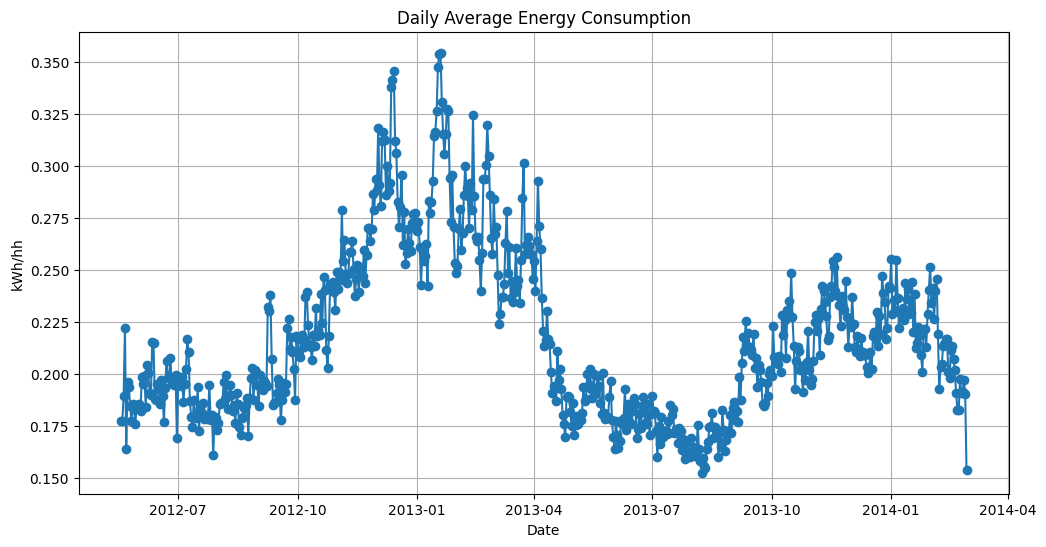

In [9]:
#plotting the data
plt.figure(figsize=(12, 6))
plt.plot(daily_data['Date'], daily_data['Average KWH'], marker='o', linestyle='-')
plt.title('Daily Average Energy Consumption')
plt.xlabel('Date')
plt.ylabel('kWh/hh')
plt.grid(True)
plt.show()

In [11]:
print(daily_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 652 entries, 0 to 651
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         652 non-null    object 
 1   Average KWH  652 non-null    float64
dtypes: float64(1), object(1)
memory usage: 10.3+ KB
None


#Now calling daily weather data from drive.

In [12]:
file_path = '/content/drive/My Drive/weather-data.csv'
weatherdf = pd.read_csv(file_path)
print(weatherdf.head(3))

         time  weather_code (wmo code)  temperature_2m_max (°C)  \
0  01/11/2011                       51                     15.0   
1  02/11/2011                       51                     14.2   
2  03/11/2011                       53                     15.6   

   temperature_2m_min (°C)  temperature_2m_mean (°C)  \
0                      8.9                      13.1   
1                      8.4                      11.4   
2                     12.9                      14.6   

   apparent_temperature_max (°C)  apparent_temperature_min (°C)  \
0                           13.2                            7.1   
1                           12.1                            6.0   
2                           13.7                           11.9   

   apparent_temperature_mean (°C) sunrise (iso8601)  sunset (iso8601)  \
0                            11.3  2011-11-01T07:53  2011-11-01T17:34   
1                             8.6  2011-11-02T07:55  2011-11-02T17:33   
2                 

In [13]:
# Converting the time column to datetime format.
weatherdf['Date'] = pd.to_datetime(weatherdf['time'], dayfirst=True)
weatherdf.head()

,time,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),sunrise (iso8601),sunset (iso8601),daylight_duration (s),sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_direction_10m_dominant (°),Date
0,01/11/2011,51,15.0,8.9,13.1,13.2,7.1,11.3,2011-11-01T07:53,2011-11-01T17:34,34876.89,23635.93,0.9,0.9,5,18.8,205,2011-11-01
1,02/11/2011,51,14.2,8.4,11.4,12.1,6.0,8.6,2011-11-02T07:55,2011-11-02T17:33,34662.17,24176.65,1.6,1.6,5,23.4,142,2011-11-02
2,03/11/2011,53,15.6,12.9,14.6,13.7,11.9,12.8,2011-11-03T07:57,2011-11-03T17:31,34448.32,899.05,4.1,4.1,15,25.8,163,2011-11-03
3,04/11/2011,61,14.9,11.1,12.7,12.8,10.2,11.4,2011-11-04T07:59,2011-11-04T17:29,34235.54,10425.34,12.8,12.8,16,19.6,177,2011-11-04
4,05/11/2011,51,13.9,8.6,11.4,12.0,7.5,9.7,2011-11-05T08:00,2011-11-05T17:27,34024.06,6934.98,0.4,0.4,4,19.0,355,2011-11-05


In [14]:
#Checking for missing values

missing_values_per_column = weatherdf.isnull().sum()
print(missing_values_per_column)

time                               0
weather_code (wmo code)            0
temperature_2m_max (°C)            0
temperature_2m_min (°C)            0
temperature_2m_mean (°C)           0
apparent_temperature_max (°C)      0
apparent_temperature_min (°C)      0
apparent_temperature_mean (°C)     0
sunrise (iso8601)                  0
sunset (iso8601)                   0
daylight_duration (s)              0
sunshine_duration (s)              0
precipitation_sum (mm)             0
rain_sum (mm)                      0
precipitation_hours (h)            0
wind_speed_10m_max (km/h)          0
wind_direction_10m_dominant (°)    0
Date                               0
dtype: int64


In [15]:
# Convert 'Date' columns to datetime in both DataFrames
daily_data['Date'] = pd.to_datetime(daily_data['Date'])
weatherdf['Date'] = pd.to_datetime(weatherdf['Date'])

# Now merge the DataFrames
merged_df = pd.merge(daily_data, weatherdf, on='Date')
print(merged_df.head())
merged_df = pd.merge(daily_data, weatherdf, on='Date')
print(merged_df.head())

        Date  Average KWH        time  weather_code (wmo code)  \
0 2012-05-18     0.177275  18/05/2012                       51   
1 2012-05-19     0.177462  19/05/2012                        3   
2 2012-05-20     0.189562  20/05/2012                       51   
3 2012-05-21     0.222067  21/05/2012                        3   
4 2012-05-22     0.163837  22/05/2012                        3   

   temperature_2m_max (°C)  temperature_2m_min (°C)  temperature_2m_mean (°C)  \
0                     15.1                      8.0                      11.9   
1                     16.8                      9.6                      13.1   
2                     15.0                      7.2                      10.8   
3                     17.2                      8.4                      12.3   
4                     23.0                      9.6                      16.2   

   apparent_temperature_max (°C)  apparent_temperature_min (°C)  \
0                           13.4                 

In [16]:
print("Weather data date range:", weatherdf['Date'].min(), weatherdf['Date'].max())

Weather data date range: 2011-11-01 00:00:00 2014-02-28 00:00:00


#Plot of energy consumption and temperature.

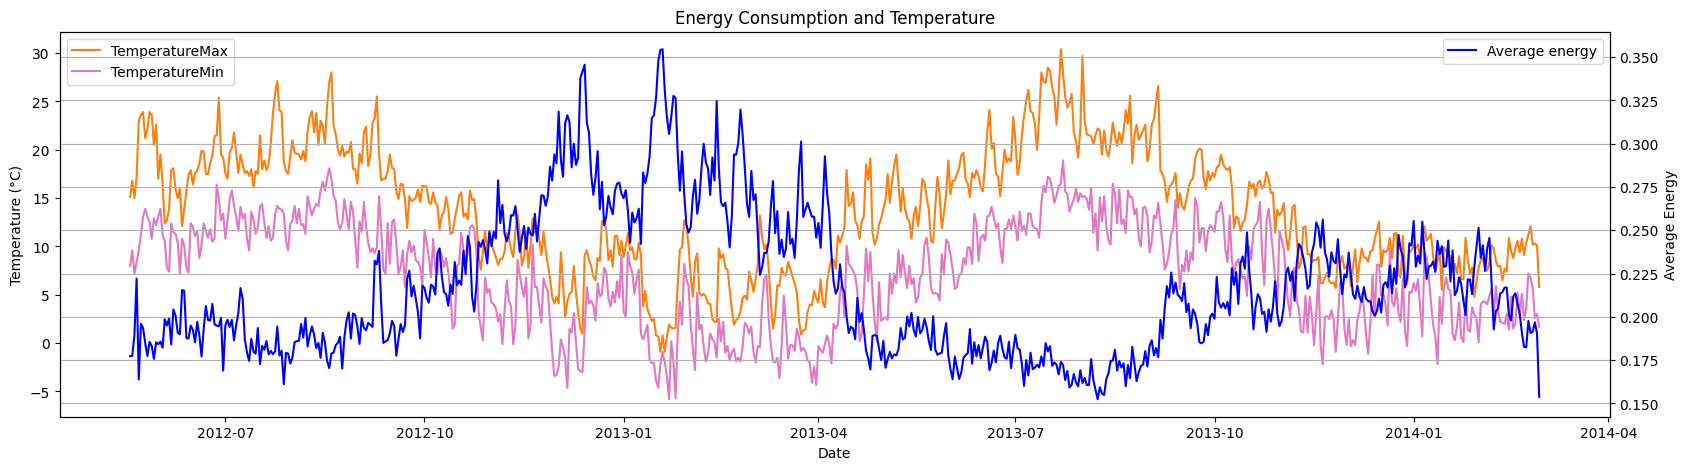

In [17]:
# Plotting
fig, ax1 = plt.subplots(figsize=(20, 5))

# Plot temperature data
ax1.plot(merged_df['Date'], merged_df['temperature_2m_max (°C)'], color='tab:orange', label='TemperatureMax')
ax1.plot(merged_df['Date'], merged_df['temperature_2m_min (°C)'], color='tab:pink', label='TemperatureMin')
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature (°C)')
ax1.legend(loc='upper left')
# Create a second y-axis for energy consumption
ax2 = ax1.twinx()
ax2.plot(merged_df['Date'], merged_df['Average KWH'], color='blue', label='Average energy')
ax2.set_ylabel('Average Energy')
ax2.legend(loc='upper right')
# Title and grid
plt.title('Energy Consumption and Temperature')
plt.grid()

plt.show()

**Interpretation**
The graph above shows that energy consumption and temperature have a strong negative correlation.

*   Rather than plotting many graphs to check correlation among different
variables and energy consumption we move to correlation matrix to observe all correlations simultaneously*


In [18]:
# Select only numeric columns as correlation requires data to be numeric.
numeric_cols = ['Average KWH', 'temperature_2m_max (°C)', 'temperature_2m_min (°C)',
                'temperature_2m_mean (°C)', 'apparent_temperature_max (°C)',
                'apparent_temperature_min (°C)', 'apparent_temperature_mean (°C)',
                'daylight_duration (s)', 'sunshine_duration (s)', 'precipitation_sum (mm)',
                'rain_sum (mm)', 'precipitation_hours (h)', 'wind_speed_10m_max (km/h)',
                'wind_direction_10m_dominant (°)']
numeric_cols = [col for col in numeric_cols if col in merged_df.columns]

# Calculating correlation matrix
cor_matrix = merged_df[numeric_cols].corr()
cor_matrix

,Average KWH,temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),daylight_duration (s),sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_direction_10m_dominant (°)
Average KWH,1.000000,-0.809493,-0.737777,-0.797130,-0.780285,-0.740729,-0.777642,-0.719163,-0.530457,0.068417,0.036542,0.091715,0.143114,-0.075580
temperature_2m_max (°C),-0.809493,1.000000,0.908114,0.980787,0.987518,0.927994,0.978586,0.727744,0.547600,-0.063890,-0.037875,-0.116702,-0.227628,0.063707
temperature_2m_min (°C),-0.737777,0.908114,1.000000,0.966025,0.895182,0.984767,0.949249,0.640874,0.350575,0.057315,0.078649,0.049243,-0.103519,0.078802
temperature_2m_mean (°C),-0.797130,0.980787,0.966025,1.000000,0.967713,0.971274,0.989509,0.702588,0.465494,-0.006833,0.017717,-0.039861,-0.168901,0.075386
apparent_temperature_max (°C),-0.780285,0.987518,0.895182,0.967713,1.000000,0.929247,0.984521,0.707225,0.509098,-0.057475,-0.032947,-0.110803,-0.330823,0.050561
apparent_temperature_min (°C),-0.740729,0.927994,0.984767,0.971274,0.929247,1.000000,0.974631,0.650896,0.363127,0.022780,0.044694,0.006155,-0.223006,0.066136
apparent_temperature_mean (°C),-0.777642,0.978586,0.949249,0.989509,0.984521,0.974631,1.000000,0.694490,0.449557,-0.026500,-0.002854,-0.062335,-0.288377,0.062477
daylight_duration (s),-0.719163,0.727744,0.640874,0.702588,0.707225,0.650896,0.694490,1.000000,0.583150,-0.062258,-0.050605,-0.055138,-0.237091,-0.086926
sunshine_duration (s),-0.530457,0.547600,0.350575,0.465494,0.509098,0.363127,0.449557,0.583150,1.000000,-0.295411,-0.279256,-0.360921,-0.196562,-0.025494
precipitation_sum (mm),0.068417,-0.063890,0.057315,-0.006833,-0.057475,0.022780,-0.026500,-0.062258,-0.295411,1.000000,0.993737,0.828139,0.344226,-0.036344


#Making heatmap to present correlation matrix

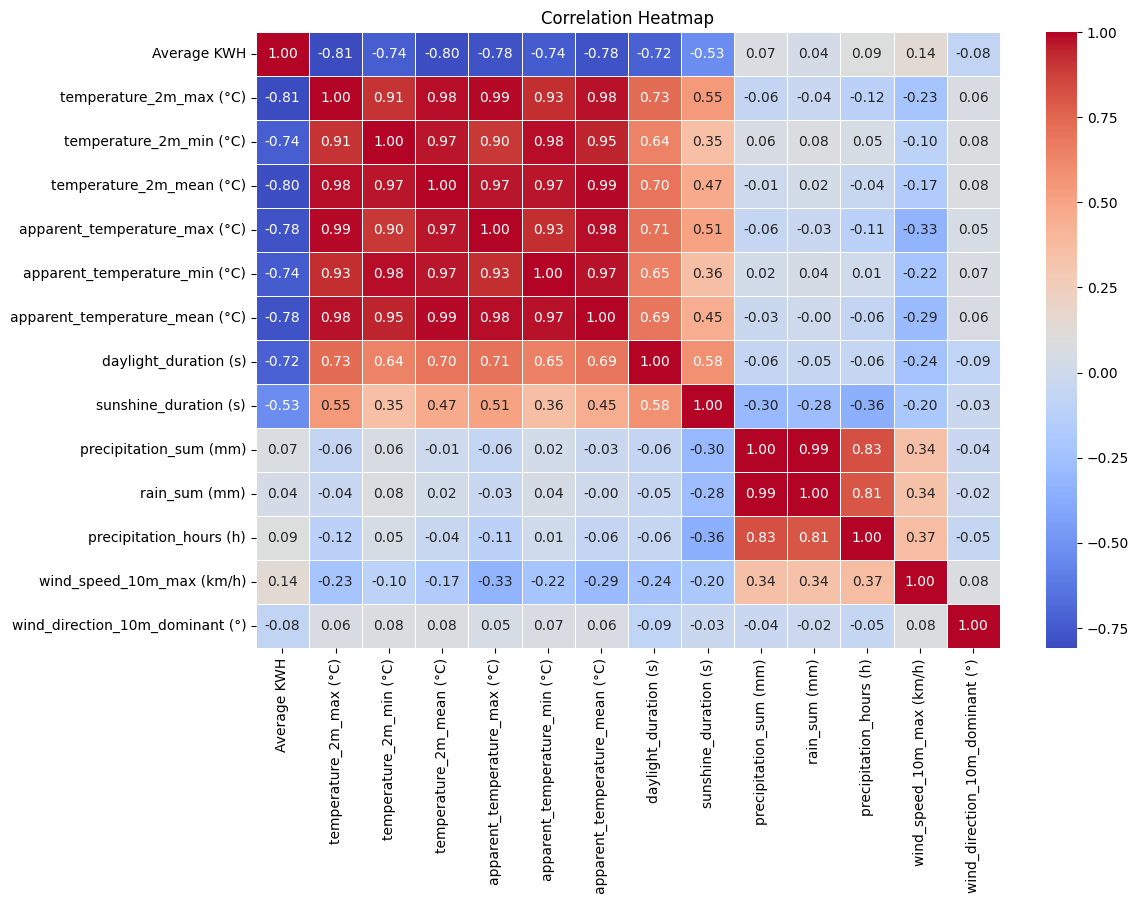

In [19]:

plt.figure(figsize=(12, 8))

# Drawing the heatmap with the obtained correlation matrix
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Adding labels to graph
plt.title('Correlation Heatmap')
plt.show()

**Interpretation:**

It can be observed that various weather variables and average energy consumption have different correlations. Temperature variables show a strong negative correlation (-0.81, -0.74, 0.80, -0.78) with energy consumption. Also, daylight duration has a strong negative correlation (-0.72) with energy consumption. So, with longer daylight durations and higher temperatures, a decrease in energy consumption is observed. On the other hand, wind speed has a weak positive correlation (0.14) with energy consumption.

#**SARIMAX MODEL**

In [20]:
#scaling
scaler = MinMaxScaler()
weather = scaler.fit_transform(merged_df[['temperature_2m_max (°C)']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

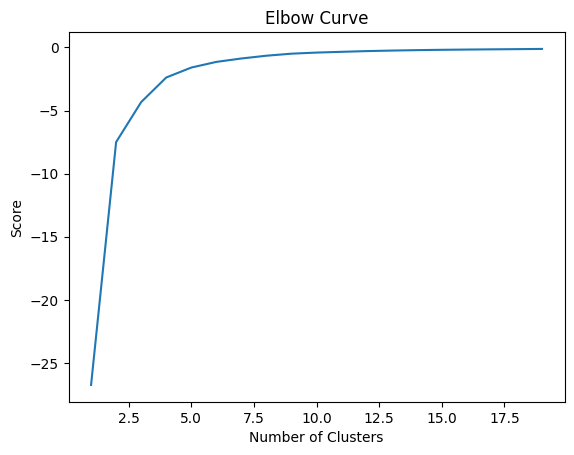

In [21]:
# optimum K
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(weather).score(weather) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

**Interpretation:**

##???

In [22]:
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
kmeans.fit(weather)
merged_df['weather_cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='auto' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


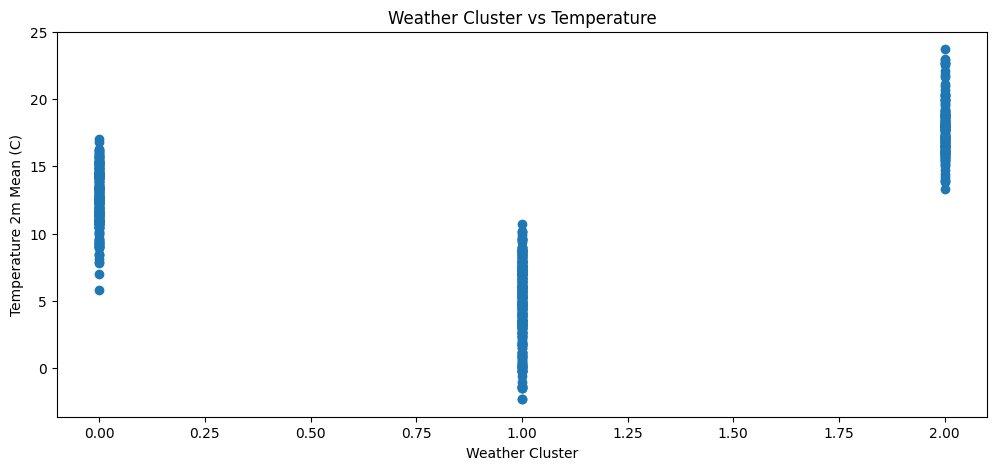

In [27]:
# Renaming the column to avoid errors
merged_df.rename(columns={'temperature_2m_mean (°C)': 'temperature_2m_mean_C'}, inplace=True)

# Now using the new column name for plotting
# Cluster Relationships with weather variables
plt.figure(figsize=(12,5))
plt.scatter(merged_df['weather_cluster'], merged_df['temperature_2m_mean_C'])
plt.xlabel('Weather Cluster')
plt.ylabel('Temperature 2m Mean (C)')
plt.title('Weather Cluster vs Temperature')
plt.show()

**Interpretation:**

Three clusters have been formed

weather cluster = 0 = medium temperature values

weather cluster = 1 = low temperature values

weather cluster = 2 = high temperature values

#

In [29]:
merged_df.head(2)

,Date,Average KWH,time,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean_C,apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),sunrise (iso8601),sunset (iso8601),daylight_duration (s),sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_direction_10m_dominant (°),weather_cluster
0,2012-05-18,0.177275,18/05/2012,51,15.1,8.0,11.9,13.4,4.5,9.5,2012-05-18T05:03,2012-05-18T20:50,56791.92,21457.15,0.3,0.3,3,17.9,98,0
1,2012-05-19,0.177462,19/05/2012,3,16.8,9.6,13.1,15.6,7.4,11.0,2012-05-19T05:02,2012-05-19T20:51,56957.59,36445.81,0.0,0.0,0,17.1,257,0


In [30]:
model_data = merged_df[['Average KWH', 'weather_cluster', 'Date']]


# Compute the index for a 80-20 split
split_index = int(len(model_data) * 0.8)

# Split the data into train and test sets
train_data = model_data.iloc[:split_index]
test_data = model_data.iloc[split_index:]

In [34]:
train_data.tail()

,Average KWH,weather_cluster,Date
516,0.248778,0,2013-10-16
517,0.227297,0,2013-10-17
518,0.213321,0,2013-10-18
519,0.192746,0,2013-10-19
520,0.206067,0,2013-10-20


In [32]:
test_data.head()

,Average KWH,weather_cluster,Date
521,0.213047,0,2013-10-21
522,0.210852,0,2013-10-22
523,0.201669,0,2013-10-23
524,0.202878,0,2013-10-24
525,0.191356,0,2013-10-25


In [35]:
# Assuming 'Date' is a column in your DataFrames
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)


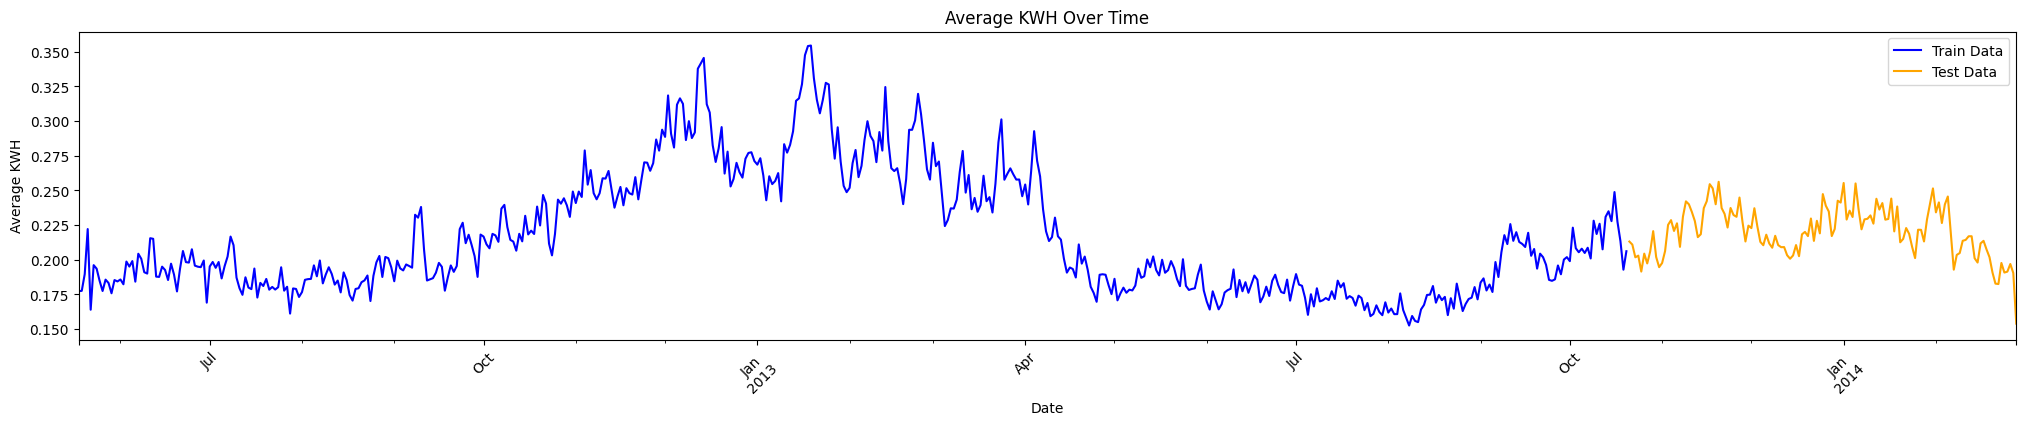

In [36]:
# Plotting train data
train_data['Average KWH'].plot(figsize=(25, 4), color='blue', label='Train Data')

# Plotting test data on the same plot
test_data['Average KWH'].plot(figsize=(25, 4), color='orange', label='Test Data')

# Add title, labels, and legend
plt.title('Average KWH Over Time')
plt.xlabel('Date')
plt.ylabel('Average KWH')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()

# Display the plot
plt.show()


<Axes: >

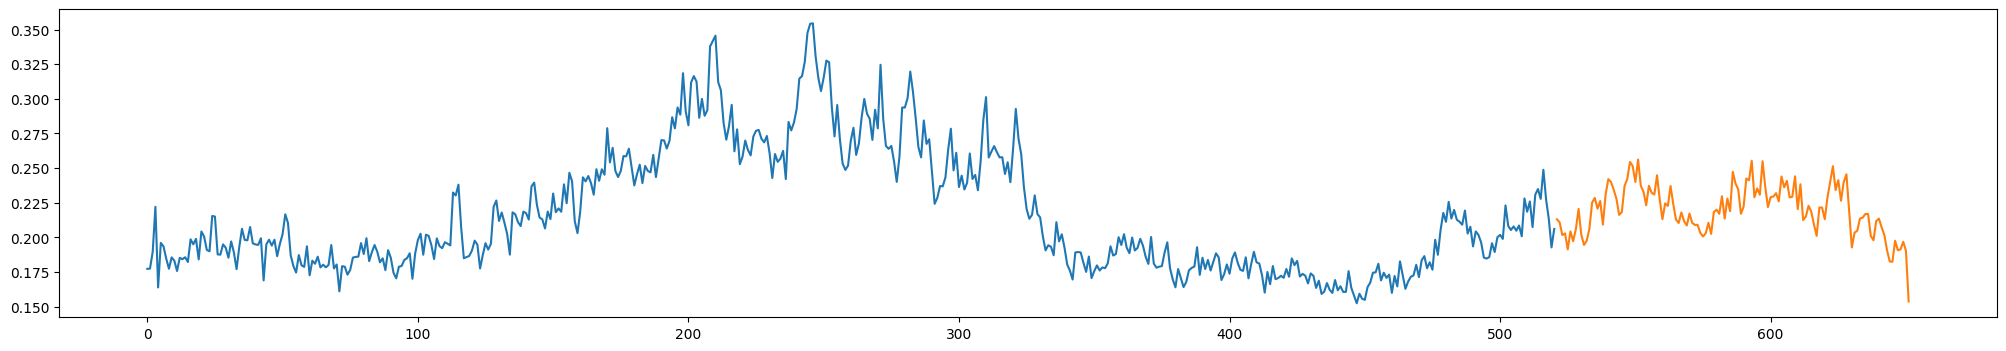

In [33]:
train_data['Average KWH'].plot(figsize=(25,4))
test_data['Average KWH'].plot(figsize=(25,4))

#Plotting ACF PACF

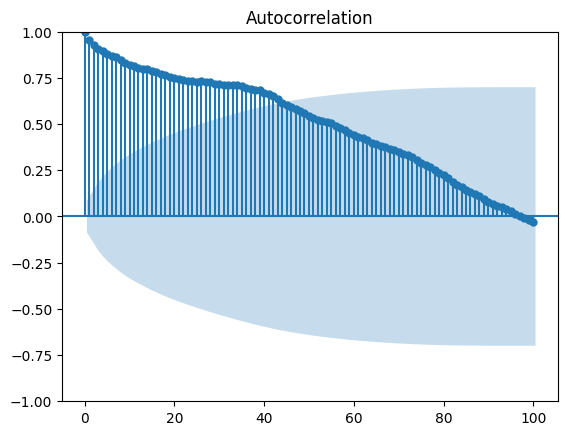

In [26]:
plot_acf(train_data['Average KWH'],lags=100)
plt.show()

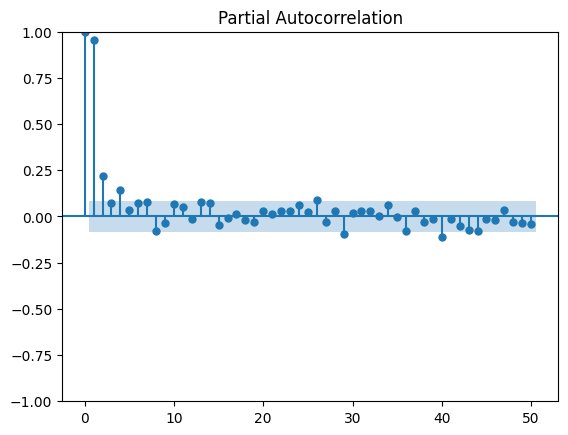

In [27]:
plot_pacf(train_data['Average KWH'],lags=50)
plt.show()

**H0: Data is not stationary.**

**H1: Data is stationary.**

To test this hypothesis we use Augmented Dickey Fuller(ADF) test

In [28]:

t = sm.tsa.adfuller(train_data['Average KWH'], autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])

,0
Test Statistic,-1.55336
p-value,0.50697
Lags Used,13.00000
Number of Observations Used,507.00000


**Interpretation:**
As p-value is greater than 0.05 also test statistics is not very negative, so we fail to reject the  null hypothesis and conclude that data is non-stationary.

#To make it stationary we use differencing.

In [29]:
# function for differencing
def difference(dataset, interval):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset.iloc[i] - dataset.iloc[i - interval]
        diff.append(value)
    return diff

In [30]:
t  = sm.tsa.adfuller(difference(train_data['Average KWH'],1), autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','Lags','No. of observations used'])

,0
Test Statistic,-8.469520e+00
p-value,1.490736e-13
Lags,1.200000e+01
No. of observations used,5.070000e+02


Now, p-value is less than 0.05 so we reject null hypothesis and conclude that after differencing data is stationary.


**Fitting SARIMA model.**

In [31]:
# Defining dependant or endogenous variable
endog = train_data['Average KWH']

# Defining independent or exogenous variables.
exog = train_data[['weather_cluster']]

# Create the SARIMAX model without the trend component
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7, 1, 1), seasonal_order=(1, 1, 0, 14))

# Fit the model
model_fit = mod.fit()

# Summarize the model
model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         Average KWH   No. Observations:                  521
Model:             SARIMAX(7, 1, 1)x(1, 1, [], 14)   Log Likelihood                1417.500
Date:                             Thu, 15 Aug 2024   AIC                          -2812.999
Time:                                     22:55:41   BIC                          -2766.507
Sample:                                          0   HQIC                         -2794.765
                                             - 521                                         
Covariance Type:                               opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
weather_cluster    -0.0006      0.001     -0.608      0.543      -0.003       0.001
ar.L1              -0.1172      1.151     -0.102      0.919      -2.374       2.139
ar.L2              -0.0743      0.290     -0.256      0.798      -0.643       0.494
ar.L3              -0.1419      0.126     -1.125      0.260      -0.389       0.105
ar.L4              -0.0690      0.184     -0.375      0.708      -0.430       0.292
ar.L5              -0.0133      0.112     -0.118      0.906      -0.234       0.207
ar.L6              -0.0509      0.057     -0.890      0.374      -0.163       0.061
ar.L7               0.0396      0.078      0.510      0.610      -0.113       0.192
ma.L1              -0.1284      1.155     -0.111      0.912      -2.393       2.136
ar.S.L14           -0.5108      0.032    -15.722      0.000      -0.574      -0.447
sigma2              0.0002   1.16e-05     18.476      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                16.61
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

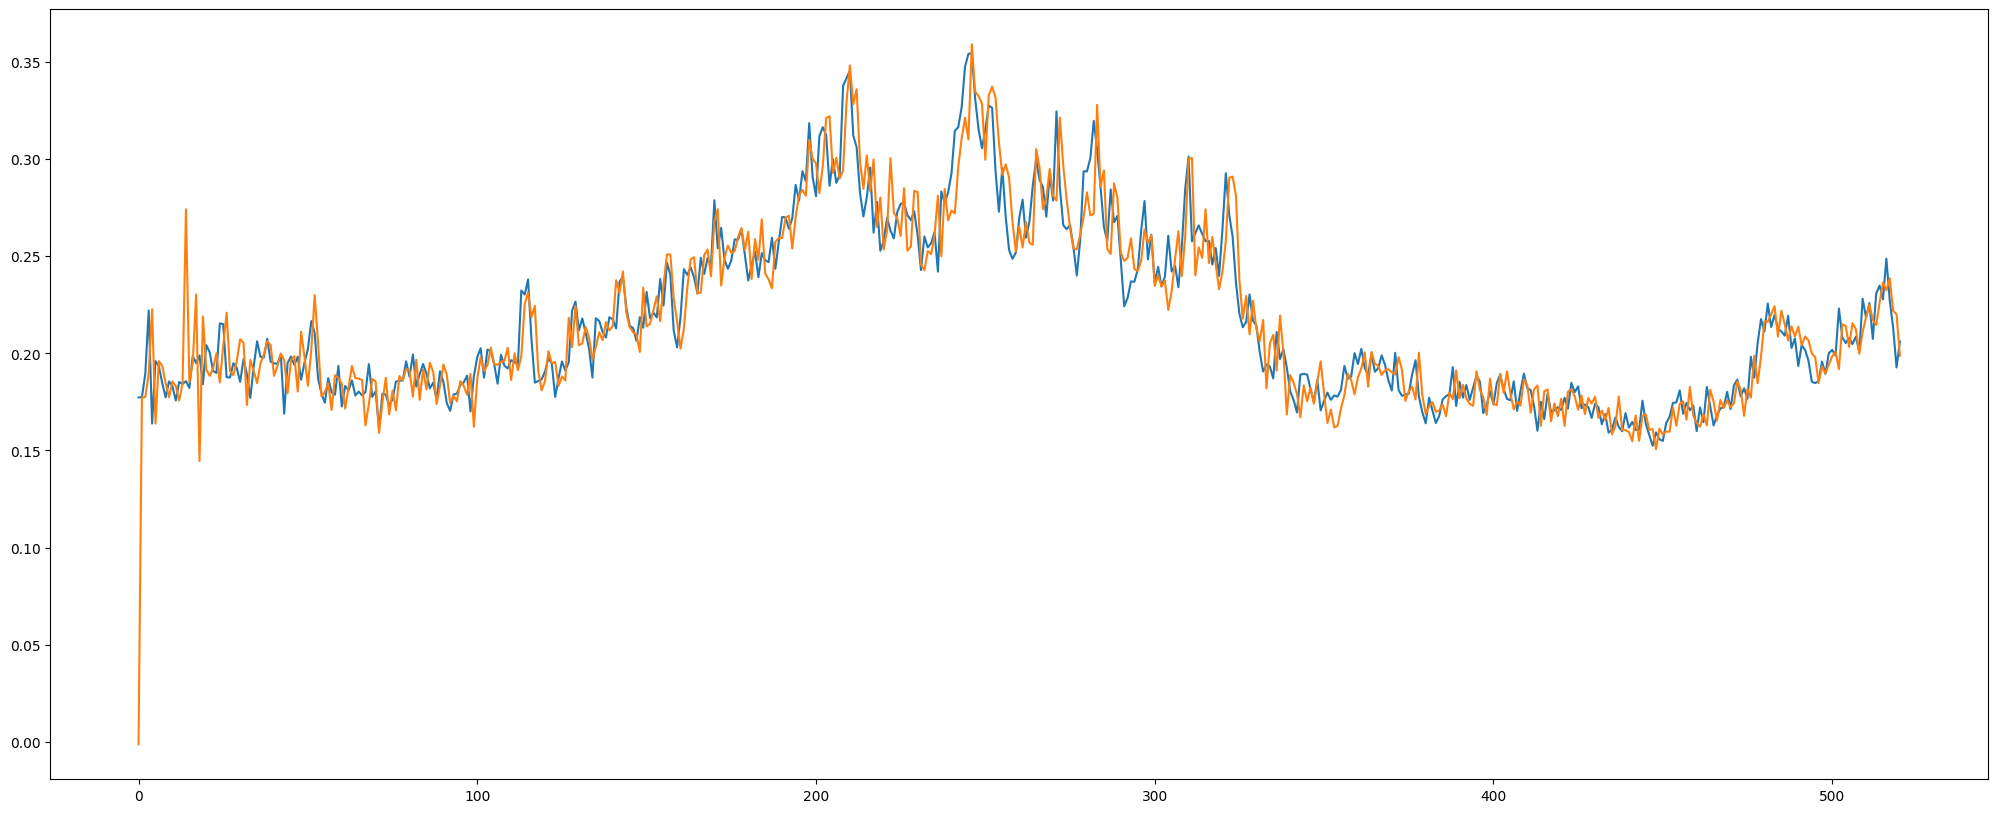

In [32]:
train_data['Average KWH'].plot(figsize=(25,10))
model_fit.fittedvalues.plot()
plt.show()

In [33]:
# Define endogenous (dependent) variable
endog = train_data['Average KWH']
# Define exogenous (independent) variables
exog = train_data[['weather_cluster']]
# Add a constant to the exogenous variables
exog = sm.add_constant(exog)
# Create the SARIMAX model with the exogenous data
mod = sm.tsa.statespace.SARIMAX(endog=endog, exog=exog, order=(7, 1, 1), seasonal_order=(1, 1, 0, 14))
# Fit the model
model_fit = mod.fit()
# Summarize the model
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                         Average KWH   No. Observations:                  521
Model:             SARIMAX(7, 1, 1)x(1, 1, [], 14)   Log Likelihood                1417.492
Date:                             Thu, 15 Aug 2024   AIC                          -2810.984
Time:                                     22:56:57   BIC                          -2760.266
Sample:                                          0   HQIC                         -2791.093
                                             - 521                                         
Covariance Type:                               opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1.008e-11   1.16e-07   8.67e-05      1.000   -2.28e-07    2.28e-07
weather_clus

In [34]:
predict = model_fit.predict(start = len(train_data),end = len(train_data)+len(test_data)-1,exog = sm.add_constant(test_data[['weather_cluster']]))
test_data['predicted'] = predict.values
test_data.head(100)




<ipython-input-34-df9370d96293>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['predicted'] = predict.values


,Average KWH,weather_cluster,predicted
521,0.213047,2,0.206364
522,0.210852,2,0.198786
523,0.201669,2,0.212634
524,0.202878,2,0.207128
525,0.191356,2,0.216570
...,...,...,...
616,0.209268,0,0.236140
617,0.201093,0,0.223556
618,0.221577,0,0.231334
619,0.221522,0,0.232809


In [35]:
# Calculate MAE and MAPE
MAE = mean_absolute_error(test_data['Average KWH'], test_data['predicted'])
MAPE = mean_absolute_percentage_error(test_data['Average KWH'], test_data['predicted'])

print(f"MAE: {MAE:.4f}, MAPE: {MAPE:.2f}%")

MAE: 0.0198, MAPE: 0.09%


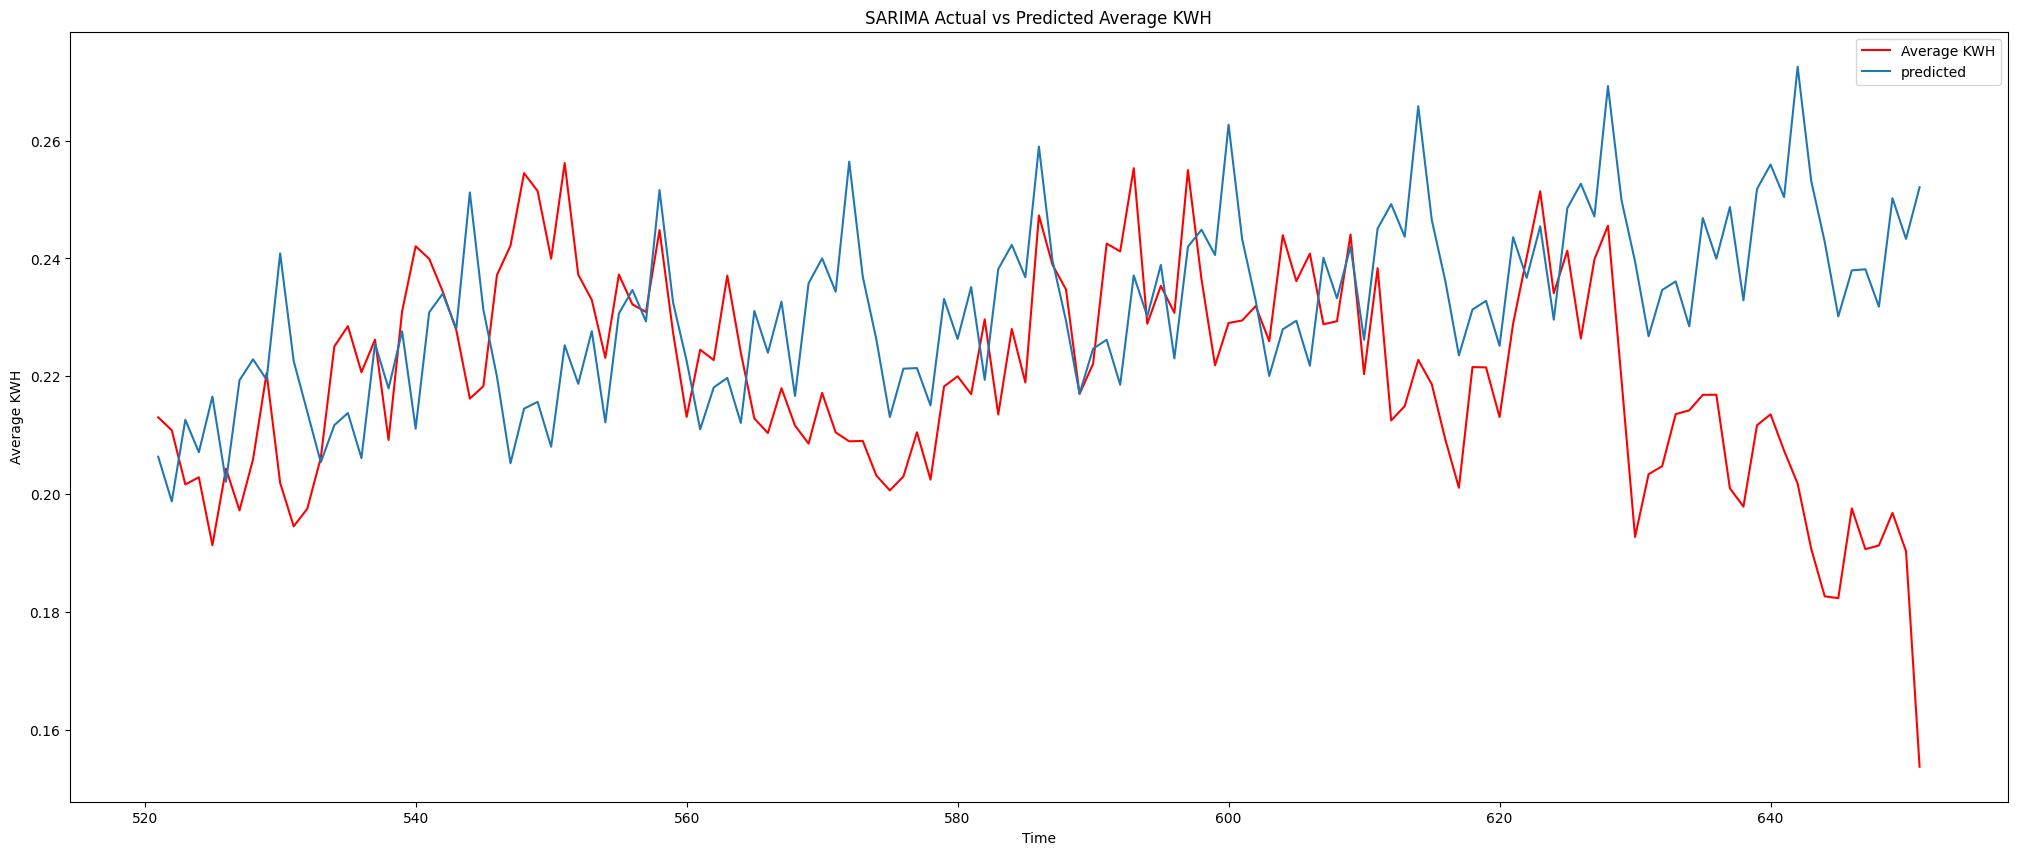

In [36]:
test_data['Average KWH'].plot(figsize=(25,10),color = 'red')
test_data['predicted'].plot()
# Add a legend to distinguish between actual and predicted values
plt.legend()
plt.title('SARIMA Actual vs Predicted Average KWH')
plt.xlabel('Time')
plt.ylabel('Average KWH')
plt.show()


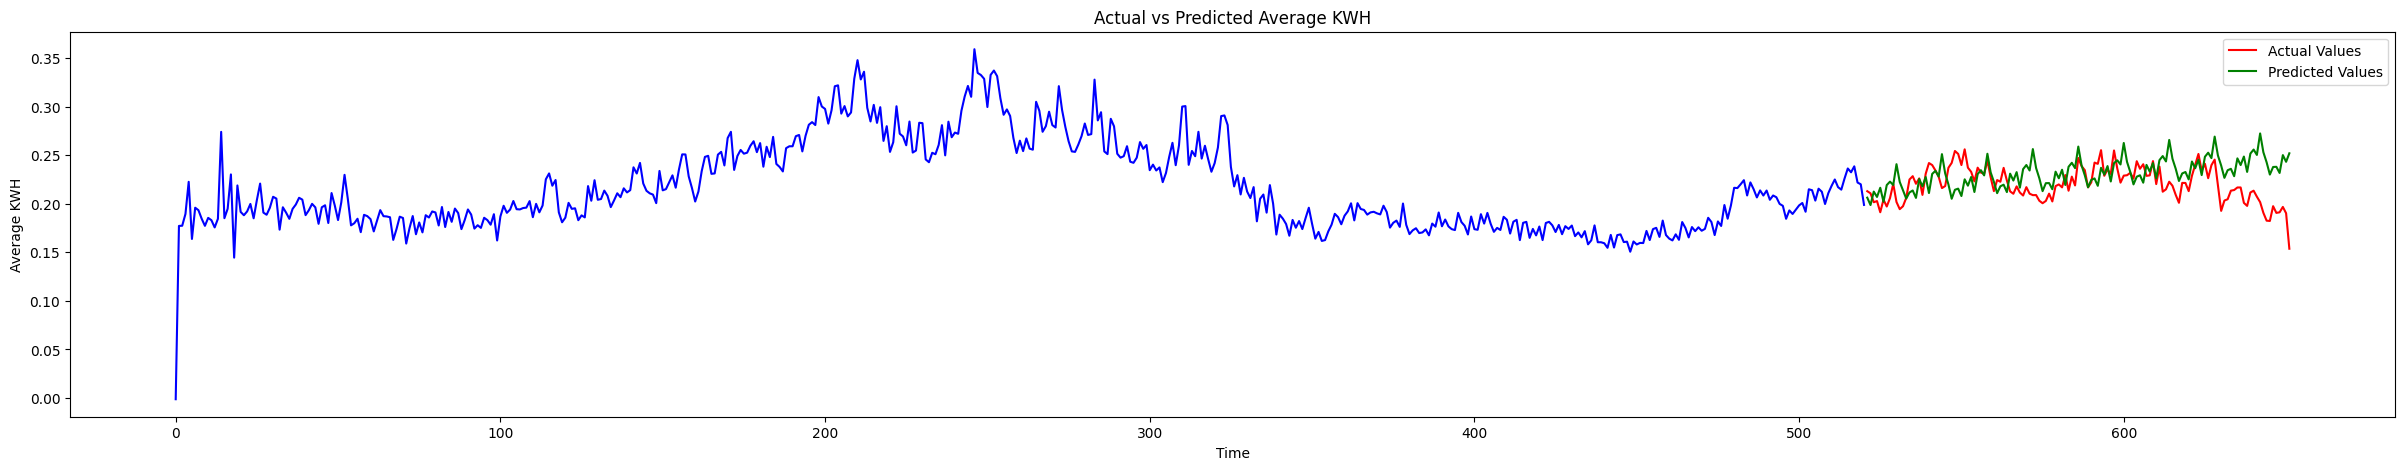

In [37]:
#Plot fitted values. actual test values and predicted test values
model_fit.fittedvalues.plot(figsize=(30, 5), color='blue')
test_data['Average KWH'].plot(color='red', label='Actual Values')
test_data['predicted'].plot(color='green', linestyle='-', label='Predicted Values')
plt.title('Actual vs Predicted Average KWH')
plt.xlabel('Time')
plt.ylabel('Average KWH')

# Add a legend to distinguish between actual, fitted, and predicted values
plt.legend()

# Show the plot
plt.show()


#**ARIMAX**

In [38]:
merged_df.head(2)

,Date,Average KWH,time,weather_code (wmo code),temperature_2m_max (°C),temperature_2m_min (°C),temperature_2m_mean_C,apparent_temperature_max (°C),apparent_temperature_min (°C),apparent_temperature_mean (°C),sunrise (iso8601),sunset (iso8601),daylight_duration (s),sunshine_duration (s),precipitation_sum (mm),rain_sum (mm),precipitation_hours (h),wind_speed_10m_max (km/h),wind_direction_10m_dominant (°),weather_cluster
0,2012-05-18,0.177275,18/05/2012,51,15.1,8.0,11.9,13.4,4.5,9.5,2012-05-18T05:03,2012-05-18T20:50,56791.92,21457.15,0.3,0.3,3,17.9,98,2
1,2012-05-19,0.177462,19/05/2012,3,16.8,9.6,13.1,15.6,7.4,11.0,2012-05-19T05:02,2012-05-19T20:51,56957.59,36445.81,0.0,0.0,0,17.1,257,2


In [39]:
import pandas as pd
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA

# Suppress warnings
warnings.filterwarnings("ignore")

# Define the p, d, and q ranges
p = range(0, 7)  # AR order
d = range(0, 2)  # Differencing
q = range(0, 4)  # MA order

# Create a list with all combinations of p, d, q
pdq = list(itertools.product(p, d, q))

# Exogenous variable(s)
exog_train = train_data[['weather_cluster']]

# Initialize a DataFrame to store the results
results = []

# Iterate over all combinations
for param in pdq:
    try:
        # Fit ARIMAX model
        model = ARIMA(train_data['Average KWH'], order=param, exog=exog_train)
        model_fit = model.fit()

        # Save the results
        results.append((param, model_fit.aic))
    except:
        continue

# Create a DataFrame from the results
result_df = pd.DataFrame(results, columns=['(p,d,q)', 'AIC'])

# Find the best combination (lowest AIC)
best_param = result_df.loc[result_df['AIC'].idxmin()]

print(f"Best ARIMAX Model: {best_param['(p,d,q)']} with AIC = {best_param['AIC']:.2f}")


Best ARIMAX Model: (1, 0, 3) with AIC = -3052.83


In [40]:
# Exogenous variable(s)
exog_train = train_data[['weather_cluster']]
exog_test = test_data[['weather_cluster']]

# Fit the ARIMAX model
model = ARIMA(train_data['Average KWH'], order=(1, 0, 3), exog=exog_train)
model_fit = model.fit()

# Summarize the model
print(model_fit.summary())



                               SARIMAX Results                                
Dep. Variable:            Average KWH   No. Observations:                  521
Model:                 ARIMA(1, 0, 3)   Log Likelihood                1533.413
Date:                Thu, 15 Aug 2024   AIC                          -3052.826
Time:                        23:02:56   BIC                          -3023.036
Sample:                             0   HQIC                         -3041.157
                                - 521                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2156      0.012     17.303      0.000       0.191       0.240
weather_cluster    -0.0017      0.001     -1.469      0.142      -0.004       0.001
ar.L1               0.9730      

In [44]:
# Predict the test set
predictions = model_fit.predict(start=len(train_data),
                                end=len(train_data) + len(test_data) - 1,
                                exog=exog_test)

# Add the predictions to the test_data DataFrame
test_data['predicted'] = predictions



In [45]:


# Calculate MAE and MAPE
mae = mean_absolute_error(test_data['Average KWH'], test_data['predicted'])
mape = mean_absolute_percentage_error(test_data['Average KWH'], test_data['predicted'])

print(f"MAE: {mae:.4f}, MAPE: {mape:.2f}%")


MAE: 0.0147, MAPE: 0.07%


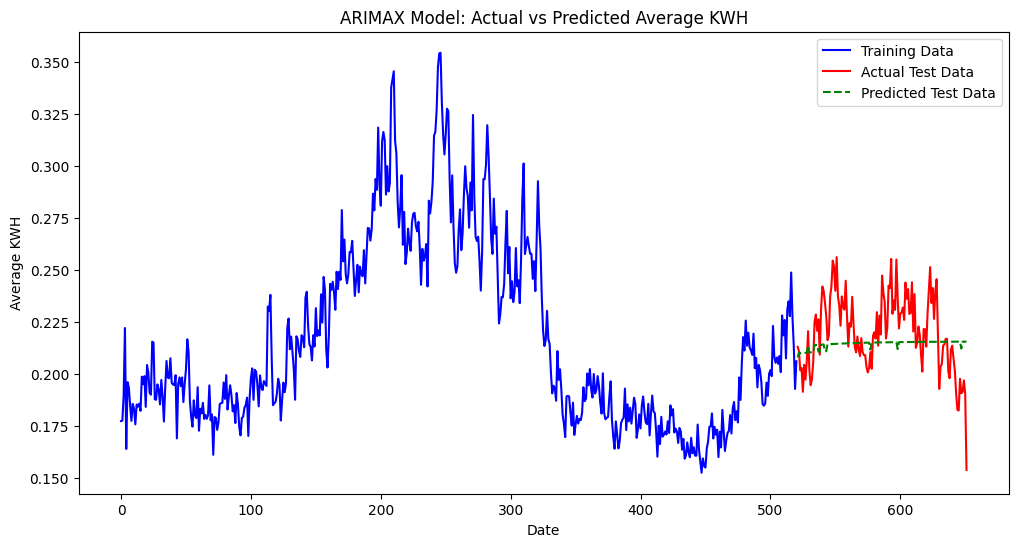

In [46]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Average KWH'], color='blue', label='Training Data')
plt.plot(test_data.index, test_data['Average KWH'], color='red', label='Actual Test Data')
plt.plot(test_data.index, test_data['predicted'], color='green', linestyle='dashed', label='Predicted Test Data')
plt.xlabel('Date')
plt.ylabel('Average KWH')
plt.title('ARIMAX Model: Actual vs Predicted Average KWH')
plt.legend()
plt.show()


**Applying log-transformation to data.**

In [47]:
# Log transform using .loc to avoid SettingWithCopyWarning
train_data.loc[:, 'log_Average KWH'] = np.log(train_data['Average KWH'])
test_data.loc[:, 'log_Average KWH'] = np.log(test_data['Average KWH'])

In [48]:
# Fit ARIMA model
ARIMAmodel = ARIMA(train_data['log_Average KWH'], order=(1, 0, 3), exog=exog_train)
ARIMAmodel_fit = ARIMAmodel.fit()
# Predict the test set
predictions1 = ARIMAmodel_fit.predict(start=len(train_data),
                                end=len(train_data) + len(test_data) - 1,
                                exog=exog_test)

# Add the predictions to the test_data DataFrame
test_data['predicted'] = predictions1




In [49]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

# Calculate MAE and MAPE
mae1 = mean_absolute_error(test_data['Average KWH'], test_data['predicted'])
mape1 = mean_absolute_percentage_error(test_data['Average KWH'], test_data['predicted'])

print(f"MAE: {mae:.4f}, MAPE: {mape:.2f}%")

MAE: 0.0147, MAPE: 0.07%


In [50]:
# Forecast
n_periods = len(test_data)
forecast_log =ARIMAmodel_fit.forecast(steps=n_periods)

# Back-transform
forecast = np.exp(forecast_log)
forecast_series = pd.Series(forecast, index=test_data.index)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train_data['Average KWH'], label='Training Data')
plt.plot(test_data['Average KWH'], label='Actual Test Data')
plt.plot(forecast_series, label='Forecast', color='red')
plt.legend(loc='upper left')
plt.title('ARIMA Model Forecast vs Actual')
plt.show()

# Calculate MAE, RMSE, MAPE
mae = mean_absolute_error(test_data['Average KWH'], forecast_series)
rmse = mean_squared_error(test_data['Average KWH'], forecast_series, squared=False)
mape = np.mean(np.abs((test_data['Average KWH'] - forecast_series) / test_data['Average KWH'])) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

ValueError: Out-of-sample operations in a model with a regression component require additional exogenous values via the `exog` argument.

#**GRU (Gated Recurrent Unit) Model**

In [51]:
# Normalize the data
scaler_kwh = MinMaxScaler()
scaler_weather = MinMaxScaler()

scaled_kwh = scaler_kwh.fit_transform(merged_df[['Average KWH']])
scaled_weather = scaler_weather.fit_transform(merged_df[['weather_cluster']])

In [52]:
# Convert the series to sequences including exogenous variables
def create_sequences(data, exog_data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        x_seq = np.hstack((data[i:(i + time_steps)], exog_data[i:(i + time_steps)]))
        X.append(x_seq)
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

In [53]:
# Define the time step
time_steps = 10  # This value tells how many values from previous data would be used to predict next value.
X, y = create_sequences(scaled_kwh, scaled_weather, time_steps)

In [54]:
# Reshaping X for GRU (samples, time steps, features)
X = X.reshape((X.shape[0], X.shape[1], 2))  # 2 features: Average KWH and weather_cluster

In [55]:
# Splitting the data into train and test datasets using 80-20% split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [57]:
# Define the GRU model
model = Sequential()
model.add(GRU(50, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 50)                  │           8,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,151 (31.84 KB)

 Trainable params: 8,151 (31.84 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.1522 - val_loss: 0.0064
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0238 - val_loss: 0.0126
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0085 - val_loss: 0.0173
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0078 - val_loss: 0.0092
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0081 - val_loss: 0.0099
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0064 - val_loss: 0.0102
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0078 - val_loss: 0.0067
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0059 - val_loss: 0.0071
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0055 - val_loss: 0.0063
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


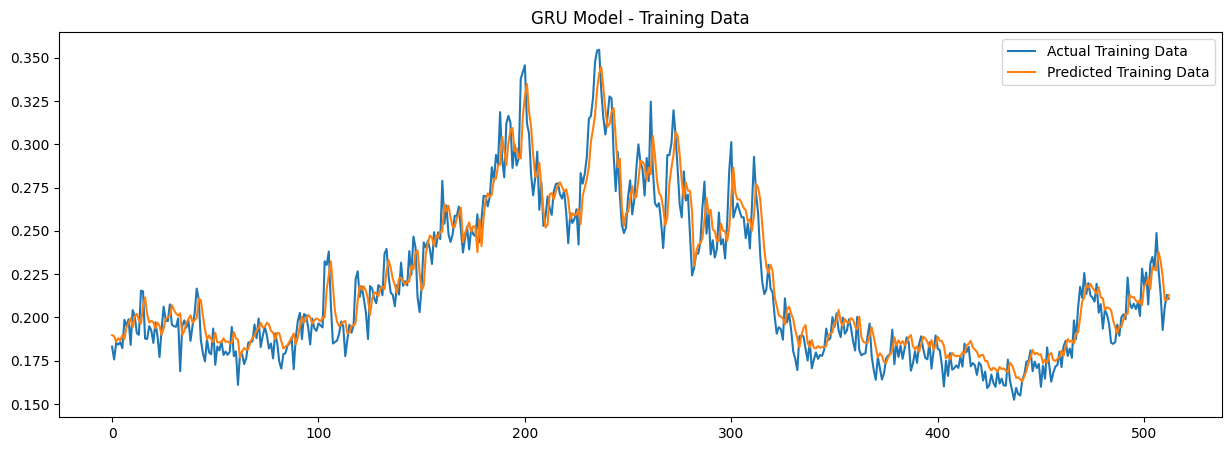

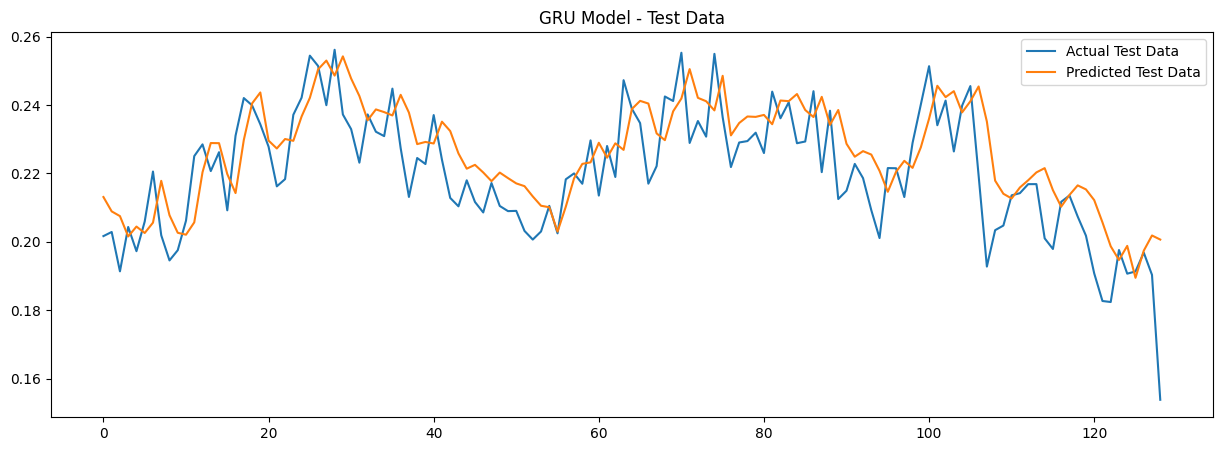

In [59]:
import matplotlib.pyplot as plt

# Make predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Invert scaling to get actual values
y_train_pred = scaler_kwh.inverse_transform(y_train_pred)
y_test_pred = scaler_kwh.inverse_transform(y_test_pred)
y_train = scaler_kwh.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler_kwh.inverse_transform(y_test.reshape(-1, 1))

# Plot the training data and predictions
plt.figure(figsize=(15, 5))
plt.plot(y_train, label='Actual Training Data')
plt.plot(y_train_pred, label='Predicted Training Data')
plt.title('GRU Model - Training Data')
plt.legend()
plt.show()

# Plot the test data and predictions
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual Test Data')
plt.plot(y_test_pred, label='Predicted Test Data')
plt.title('GRU Model - Test Data')
plt.legend()
plt.show()


In [60]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Mean Absolute Error (MAE): 0.010196987132450624
Root Mean Squared Error (RMSE): 0.012799237707120874
